In [1]:
import array
from numpy import random

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', embed_limit=30)
rc('animation', html='jshtml')

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

In [2]:
X_START = -4
X_END = 4
X_STEP = 0.5

def unknown(x):
    
    return 1.3*x + 1.9*x**2 - 4.2*x**3 + 5.0

X = np.array([x for x in np.arange(X_START, X_END, X_STEP)])

def sample(inputs):
    return np.array([unknown(inp) + random.normal(5.) for inp in inputs])

In [3]:
# observations

Y = sample(X)

data = list(zip(X, Y))

In [4]:
# some constants

IND_SIZE = 5
NGEN = 100

In [5]:
# datatypes def

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", array.array, typecode="d")

In [6]:
# register functions

# Individual generator
def generateES(ind_cls, strg_cls, size):
    ind = ind_cls(random.normal() for _ in range(size))
    ind.strategy = strg_cls(random.normal() for _ in range(size))
    return ind

toolbox = base.Toolbox()

# generation functions
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# evolutionary ops
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

def pred(ind, x):
    
    y_ = 0.0
    
    for i in range(1,IND_SIZE):
        y_ += ind[i-1]*x**i
    
    y_ += ind[IND_SIZE-1]
       
    return y_

def fitness(ind, data):
    
    mse = 0.0
    
    for x, y in data:
        
        y_ = pred(ind, x)
        mse += (y - y_)**2
        
    return mse/len(data),

# fitness eval
toolbox.register("evaluate", fitness, data=data)

In [7]:
# ES params
MU, LAMBDA = 10, 100

# register some statistics

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [8]:
# evolve and animate

def evolve_animate():
    
    random.seed()
    
    # init population
    pop = toolbox.population(n=MU)

    hof = tools.HallOfFame(1)
    
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    ax.scatter(X, Y, color='g')
    line, = ax.plot(X, np.zeros(Y.shape))

    def update(best_ind):
        
        Y_ = np.array([pred(best_ind, x) for x in X])
        
        line.set_ydata(Y_)
        
        return line,
    
    def init():
        
        return update(pop[0])
    
    def animate(i):
        
        ax.set_title('Gen: {}'.format(i+1))
        
        nonlocal pop
        
        pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, 
            cxpb=0.6, mutpb=0.3, ngen=1, stats=stats, halloffame=hof, verbose=False)
        
        best_ind = hof[0]
        
        return update(best_ind)

    ani = animation.FuncAnimation(fig, animate, np.arange(NGEN), init_func=None,
                                  interval=5, blit=True)
    return ani

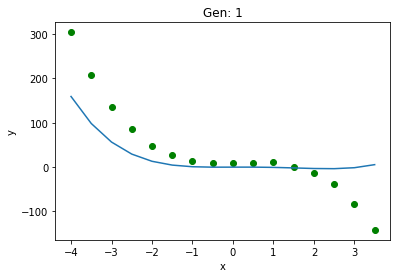

In [9]:
ani = evolve_animate()

In [10]:
ani.save('evo-ani.gif', writer='imagemagick', fps=20)